# Failing Fraction Prediction.
Input: 3 first time windows of the task, represented in a 72x147 table with 73 sites and 147 exit codes, where the first column (0) is exit code 0 -- successful job 
Label: Failure fraction derived from the last time window layer showing the overall picture of the task

In [88]:
import matplotlib.pyplot as plt 
from matplotlib.colors import LogNorm
%load_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np
import h5py

from keras.models import Model, Sequential
from keras import layers
#from keras.layers import Input, Dense, Flatten
from keras.utils import np_utils
from keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
from keras import optimizers
from keras import backend as K

from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

from utils import show_losses, plot_confusion_matrix
from glob import glob


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import sys
print sys.path

['', '/usr/local/lib/python2.7/dist-packages/pygpu-0.6.2-py2.7-linux-x86_64.egg', '/usr/lib/python2.7/dist-packages', '/usr/local/root/lib', '/usr/lib/python2.7', '/usr/lib/python2.7/plat-x86_64-linux-gnu', '/usr/lib/python2.7/lib-tk', '/usr/lib/python2.7/lib-old', '/usr/lib/python2.7/lib-dynload', '/home/thong/.local/lib/python2.7/site-packages', '/usr/local/lib/python2.7/dist-packages', '/home/thong/.local/lib/python2.7/site-packages/IPython/extensions', '/home/thong/.ipython']


### By task or by workflow

In [3]:
#table_type = "workflow"
table_type = "task"

### Append all data to a np array

In [4]:
all_data = []
if table_type == "workflow":
    filelist = glob('/bigdata/shared/WMA/Full_byWF/*.h5')
elif table_type == "task":
    filelist = glob('/bigdata/shared/WMA/Full_wma_byTask/*.h5')
for myfile in filelist:
    with h5py.File(myfile,'r') as filein:
        for key in filein.keys():
            all_data.append(filein[key][()])

In [5]:
all_data = np.asarray(all_data) # ,dtype=np.int16 because of the freaking memory error

In [6]:
print all_data.shape
all_data_1 = all_data[:,...]
nb_sites = all_data_1.shape[1]
nb_errors = all_data_1.shape[2]
matrix_dim = nb_sites * nb_errors

(38086, 74, 159, 11)


### Normalize data

In [7]:
#norm_all_data = all_data/np.linalg.norm(all_data,axis=(1,2),keepdims=True)

In [8]:
#print norm_all_data.shape

### Number of training layers

In [9]:
train_layers = 9

In [10]:
validation_split = int(0.15 * all_data_1.shape[0])
train_split = all_data_1.shape[0]-validation_split
print validation_split

5712


In [11]:
training_data = all_data_1[:train_split,...,:train_layers]

In [12]:
print training_data.shape

(32374, 74, 159, 9)


### Obtain validation set

In [13]:
validation_data = all_data_1[train_split:,...,:train_layers]

### Get the final fraction from the last layer
OneHotEncoding needs integer input; therefore, I multiply the final fraction by ten and round it to the nearest integer.

In [14]:
whole_picture = all_data_1[...,-1]

In [15]:
print whole_picture.shape

(38086, 74, 159)


The "raw" is for regression model (no one hot encoding necessary)

In [16]:
final_fraction = np.zeros(train_split)
raw_final_fraction = np.zeros(train_split)
raw_validation_final_fraction = np.zeros(validation_split)
validation_final_fraction = np.zeros(validation_split)

In [17]:
for i in range(train_split):
    final_fraction[i] = int(round(10*(1-(whole_picture[i,:,0].sum()/whole_picture[i,:,:].sum())))) 
    raw_final_fraction[i] = 1-(whole_picture[i,:,0].sum()/whole_picture[i,:,:].sum())

In [18]:
print final_fraction[:30]

[ 10.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   1.   0.   0.   0.]


In [19]:
for i in range(train_split,all_data_1.shape[0]):
    validation_final_fraction[i-train_split] = int(round(10*(1-(whole_picture[i,:,0].sum()/whole_picture[i,:,:].sum())))) 
    raw_validation_final_fraction[i-train_split] = 1-(whole_picture[i,:,0].sum()/whole_picture[i,:,:].sum())

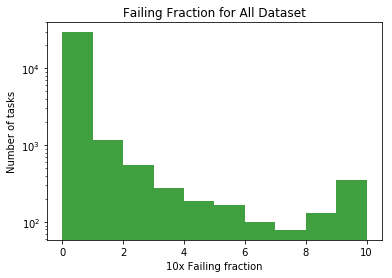

In [20]:
plt.hist(final_fraction,10,facecolor='g', alpha=0.75, log=True)
plt.xlabel('10x Failing fraction')
plt.ylabel('Number of %ss' % table_type)
plt.title('Failing Fraction for All Dataset')

In [21]:
training_label = np_utils.to_categorical(final_fraction,nb_classes=11)
validation_label = np_utils.to_categorical(validation_final_fraction,nb_classes=11)

## Binary classification (with regard to some failing threshold)

In [22]:
threshold = 0.7
target_failure = np.zeros(train_split)
validation_target_failure = np.zeros(validation_split)

target_failure[np.where(raw_final_fraction >= threshold)] = 1
target_failure[np.where(raw_final_fraction < threshold)] = 0
validation_target_failure[np.where(raw_validation_final_fraction >= threshold)] = 1
validation_target_failure[np.where(raw_validation_final_fraction < threshold)] = 0

binary_weight = len(np.where(raw_final_fraction < threshold)[0])/len(np.where(raw_final_fraction >= threshold)[0])
print binary_weight
binary_class_weight = {0:1,
                       1:binary_weight}

62


### Class weights

In [23]:
nonzeros = np.count_nonzero(final_fraction)
zeros = final_fraction.size - nonzeros
zeros_fract = zeros/nonzeros
print zeros_fract

9


In [24]:
class_weight = { 0 : 1,
                1 : zeros_fract*10,
                2 : zeros_fract*10,
                3 : zeros_fract*10,
                4 : zeros_fract*10,
                5 : zeros_fract*10,
                6 : zeros_fract*10,
                7 : zeros_fract*10,
                8 : zeros_fract*10,
                9 : zeros_fract*10,
                10 : zeros_fract*10,
               }

In [106]:
class Metrics(Callback):

    def on_train_begin(self, logs={}):
        self.val_f1s = []
        self.val_recalls = []
        self.val_precisions = []
        
    def on_epoch_end(self, epoch, logs={}):
        val_predict = (np.asarray(self.model.predict(self.model.validation_data[0]))).round()
        val_targ = self.model.validation_data[1]
        _val_f1 = f1_score(val_targ, val_predict)
        _val_recall = recall_score(val_targ, val_predict)
        _val_precision = precision_score(val_targ, val_predict)
        self.val_f1s.append(_val_f1)
        self.val_recalls.append(_val_recall)
        self.val_precisions.append(_val_precision)
        print " - val_f1: %f - val_precision: %f - val_recall %f" %(_val_f1, _val_precision, _val_recall)
        return

# Model 1: Fully connected (Binary classification)

In [26]:
i = layers.Input((nb_sites,nb_errors,train_layers))
f = layers.Flatten()(i)
layer = layers.Dense(1000, activation='relu')(f)
layer = layers.Dense(1000, activation='relu')(layer)
layer = layers.Dense(100, activation='relu')(layer)
d = layers.Dense(10, activation='relu')(layer)
o = layers.Dense(1, activation ='sigmoid')(d)

In [27]:
model = Model(i,o)

In [28]:
model.compile(optimizer='adam',loss='binary_crossentropy')

In [29]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 74, 159, 9)    0                                            
____________________________________________________________________________________________________
flatten_1 (Flatten)              (None, 105894)        0           input_1[0][0]                    
____________________________________________________________________________________________________
dense_1 (Dense)                  (None, 1000)          105895000   flatten_1[0][0]                  
____________________________________________________________________________________________________
dense_2 (Dense)                  (None, 1000)          1001000     dense_1[0][0]                    
___________________________________________________________________________________________

In [107]:
metrics_FC = Metrics()
hist = model.fit(training_data, target_failure, 
          validation_data=(validation_data, validation_target_failure),
          nb_epoch=10,
          batch_size=32,
          callbacks=[metrics_FC],
          #class_weight=binary_class_weight,
          #callbacks=[EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min'),
          #                  ModelCheckpoint(filepath='simple.h5', verbose=0)]
         )

Train on 32374 samples, validate on 5712 samples
Epoch 1/10
32374/32374 [==============================] - 42s - loss: 0.0424 - val_loss: 0.0875
Epoch 2/10
32374/32374 [==============================] - 42s - loss: 0.0428 - val_loss: 0.0857
Epoch 3/10
32374/32374 [==============================] - 42s - loss: 0.0428 - val_loss: 0.0869
Epoch 4/10
32374/32374 [==============================] - 42s - loss: 0.0420 - val_loss: 0.0896
Epoch 5/10
32374/32374 [==============================] - 42s - loss: 0.0401 - val_loss: 0.1007
Epoch 6/10
32374/32374 [==============================] - 42s - loss: 0.0385 - val_loss: 0.0982
Epoch 7/10
32374/32374 [==============================] - 42s - loss: 0.0361 - val_loss: 0.0934
Epoch 8/10
32374/32374 [==============================] - 42s - loss: 0.0392 - val_loss: 0.1046
Epoch 9/10
32374/32374 [==============================] - 42s - loss: 0.0359 - val_loss: 0.1088
Epoch 10/10
32374/32374 [==============================] - 42s - loss: 0.0362 - val_los

f1 score: 0.391555
[[5293  274]
 [  43  102]]


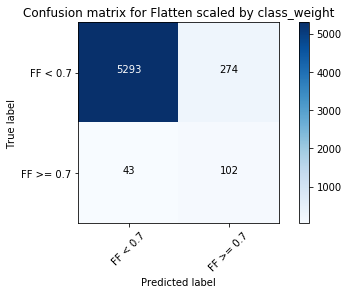

In [108]:
Flatten_unweighted_prob = model.predict(validation_data)[:,0]
Flatten_weighted_prob = Flatten_unweighted_prob/((1-Flatten_unweighted_prob)/binary_weight+Flatten_unweighted_prob)
Flatten_weighted_pred = np.round(Flatten_weighted_prob)
print "f1 score: %f" % f1_score(validation_target_failure, Flatten_weighted_pred)
Flatten_weighted_cm = confusion_matrix(validation_target_failure, Flatten_weighted_pred)
plot_confusion_matrix(Flatten_weighted_cm,["FF < %.1f"%threshold, "FF >= %.1f"%threshold],title='Confusion matrix for Flatten scaled by class_weight')

f1 score: 0.543624
[[5495   72]
 [  64   81]]


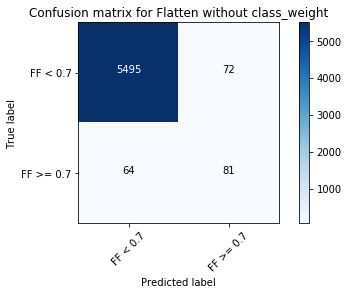

In [109]:
Flatten_unweighted_pred = np.round(Flatten_unweighted_prob)
print "f1 score: %f" % f1_score(validation_target_failure, Flatten_unweighted_pred)
Flatten_unweighted_cm = confusion_matrix(validation_target_failure, Flatten_unweighted_pred)
plot_confusion_matrix(Flatten_unweighted_cm,["FF < %.1f"%threshold, "FF >= %.1f"%threshold],title='Confusion matrix for Flatten without class_weight')

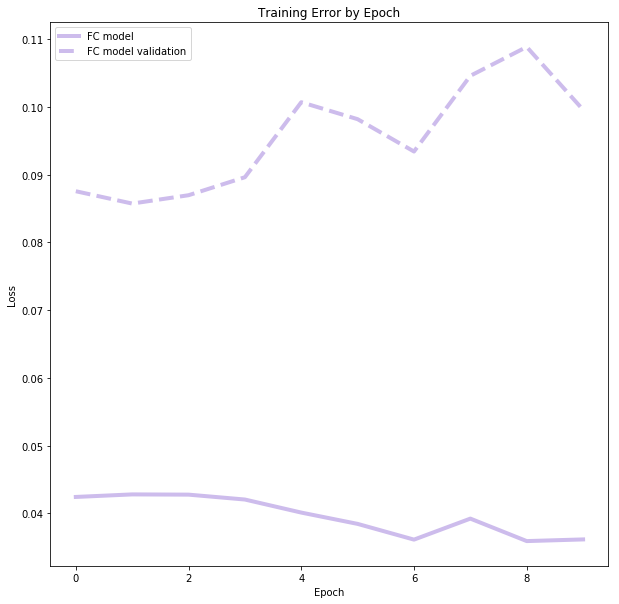

In [110]:
show_losses([("FC model", hist)],acc='binary_accuracy')

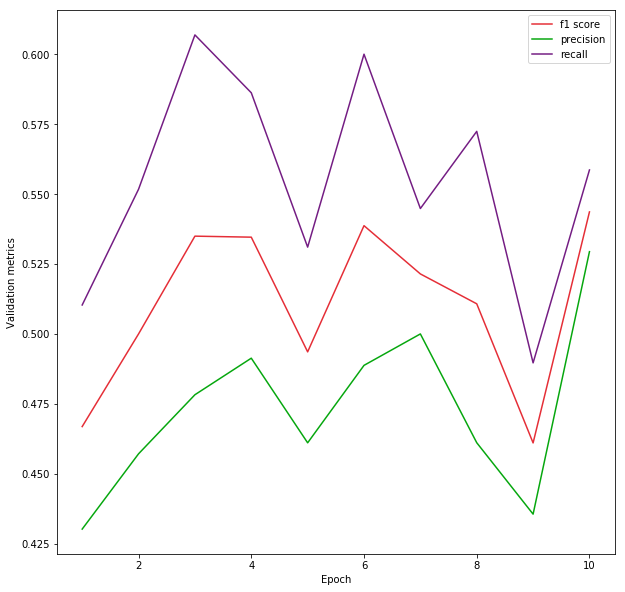

In [113]:
epoch_FC = np.arange(1,11)
plt.figure(figsize=(10,10))
plt.plot(epoch_FC, metrics_FC.val_f1s, color= tuple(np.random.random(3)),label="f1 score")
plt.plot(epoch_FC, metrics_FC.val_precisions, color= tuple(np.random.random(3)), label='precision')
plt.plot(epoch_FC, metrics_FC.val_recalls, color= tuple(np.random.random(3)), label='recall')
plt.xlabel("Epoch")
plt.ylabel("Validation metrics")
plt.legend(loc='best')
plt.show()

# Model 2: Binary classification with LSTM

In [42]:
metrics_LSTM = Metrics()

In [43]:
def build_model_2():
    main_input = layers.Input(shape=(nb_sites,nb_errors,train_layers))
    layer = layers.Permute(dims=(3,1,2), input_shape=(nb_sites,nb_errors,train_layers))(main_input)
    layer = layers.Reshape((train_layers,matrix_dim))(layer)
    layer = layers.Dense(100, input_dim = matrix_dim)(layer)
    layer = layers.LSTM(128, return_sequences=True)(layer)
    layer = layers.Dropout(0.5)(layer)
    layer = layers.LSTM(128, return_sequences=True)(layer)
    layer = layers.Dropout(0.5)(layer)
    layer = layers.LSTM(128, return_sequences=False)(layer)
    layer = layers.Dropout(0.5)(layer)
    output = layers.Dense(1, activation='sigmoid')(layer)
    model = Model(main_input,output)
    model.summary()
    model.compile(loss="binary_crossentropy", optimizer="adam")
    return model

In [47]:
# train the model
model_2 = build_model_2()

hist_2 = model_2.fit(training_data, target_failure, 
          validation_data = [validation_data, validation_target_failure],
          nb_epoch=10,
          batch_size=32,
          verbose=1,
          callbacks=[metrics_LSTM] 
          #EarlyStopping(monitor='val_f1', patience=5, verbose=1, mode='min'),
          #ModelCheckpoint(filepath='simple_9.h5', verbose=0)]
         )


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_5 (InputLayer)             (None, 74, 159, 9)    0                                            
____________________________________________________________________________________________________
permute_4 (Permute)              (None, 9, 74, 159)    0           input_5[0][0]                    
____________________________________________________________________________________________________
reshape_4 (Reshape)              (None, 9, 11766)      0           permute_4[0][0]                  
____________________________________________________________________________________________________
dense_12 (Dense)                 (None, 9, 100)        1176700     reshape_4[0][0]                  
___________________________________________________________________________________________

f1 score: 0.474419
[[5384  183]
 [  43  102]]


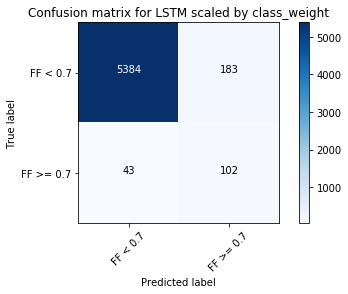

In [48]:
LSTM_unweighted_prob = model_2.predict(validation_data)[:,0]
LSTM_weighted_prob = LSTM_unweighted_prob/((1-LSTM_unweighted_prob)/binary_weight+LSTM_unweighted_prob)
LSTM_weighted_pred = np.round(LSTM_weighted_prob)
print "f1 score: %f" % f1_score(validation_target_failure, LSTM_weighted_pred)
LSTM_weighted_cm = confusion_matrix(validation_target_failure, LSTM_weighted_pred)
plot_confusion_matrix(LSTM_weighted_cm,["FF < %.1f"%threshold, "FF >= %.1f"%threshold],title='Confusion matrix for LSTM scaled by class_weight')

f1 score: 0.432203
[[5527   40]
 [  94   51]]


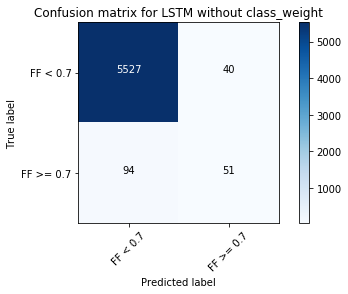

In [49]:
LSTM_unweighted_pred = np.round(LSTM_unweighted_prob)
print "f1 score: %f" % f1_score(validation_target_failure, LSTM_unweighted_pred)
LSTM_unweighted_cm = confusion_matrix(validation_target_failure, LSTM_unweighted_pred)
plot_confusion_matrix(LSTM_unweighted_cm,["FF < %.1f"%threshold, "FF >= %.1f"%threshold],title='Confusion matrix for LSTM without class_weight')

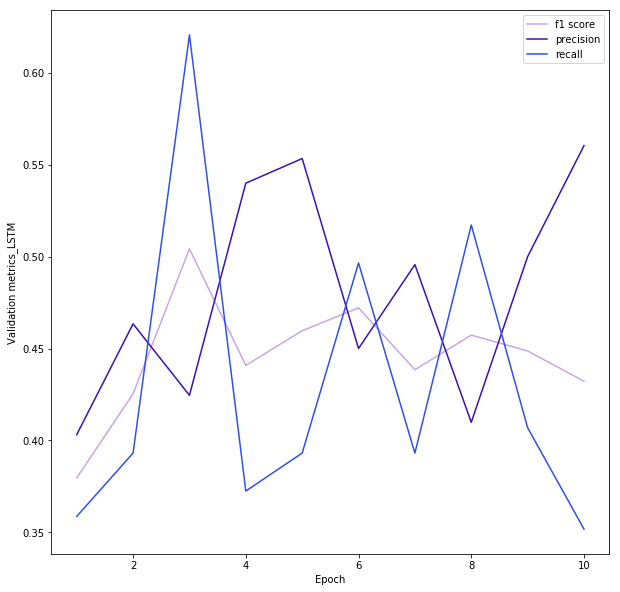

In [114]:
epoch_LSTM = np.arange(1,11)
plt.figure(figsize=(10,10))
plt.plot(epoch_LSTM, metrics_LSTM.val_f1s, color= tuple(np.random.random(3)),label="f1 score")
plt.plot(epoch_LSTM, metrics_LSTM.val_precisions, color= tuple(np.random.random(3)), label='precision')
plt.plot(epoch_LSTM, metrics_LSTM.val_recalls, color= tuple(np.random.random(3)), label='recall')
plt.xlabel("Epoch")
plt.ylabel("Validation metrics_LSTM")
plt.legend(loc='best')
plt.show()

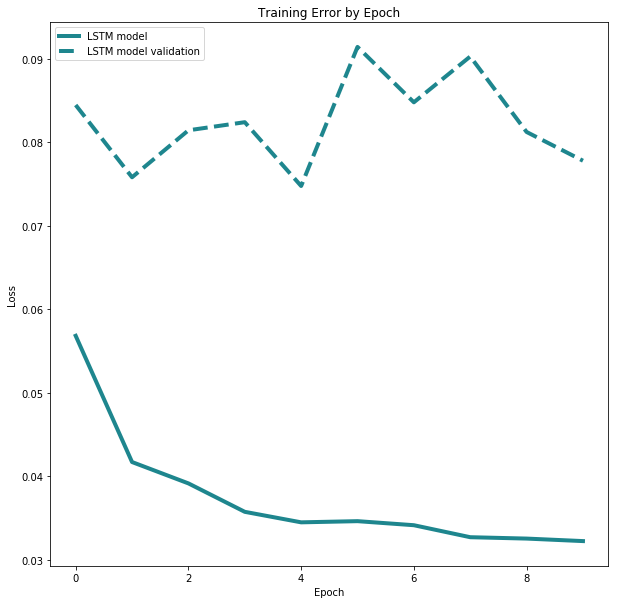

In [50]:
show_losses([("LSTM model", hist_2)],acc='binary_accuracy')

# Model 2.5: Binary classification with GRU

In [56]:
metrics_GRU = Metrics()

In [57]:
def build_model_25():
    main_input = layers.Input(shape=(nb_sites,nb_errors,train_layers))
    layer = layers.Permute(dims=(3,1,2), input_shape=(nb_sites,nb_errors,train_layers))(main_input)
    layer = layers.Reshape((train_layers,matrix_dim))(layer)
    layer = layers.Dense(100, input_dim = matrix_dim)(layer)
    layer = layers.GRU(128, return_sequences=True)(layer)
    layer = layers.Dropout(0.5)(layer)
    layer = layers.GRU(128, return_sequences=True)(layer)
    layer = layers.Dropout(0.5)(layer)
    layer = layers.GRU(128, return_sequences=False)(layer)
    layer = layers.Dropout(0.5)(layer)
    output = layers.Dense(1, activation='sigmoid')(layer)
    model = Model(main_input,output)
    model.summary()
    model.compile(loss="binary_crossentropy", optimizer="adam")
    return model

In [58]:
# train the model
model_25 = build_model_25()

hist_25 = model_25.fit(training_data, target_failure, 
          validation_data = [validation_data, validation_target_failure],
          nb_epoch=10,
          batch_size=32,
          verbose=1,
          callbacks=[metrics_GRU] 
          #EarlyStopping(monitor='val_f1', patience=5, verbose=1, mode='min'),
          #ModelCheckpoint(filepath='simple_9.h5', verbose=0)]
         )


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_7 (InputLayer)             (None, 74, 159, 9)    0                                            
____________________________________________________________________________________________________
permute_6 (Permute)              (None, 9, 74, 159)    0           input_7[0][0]                    
____________________________________________________________________________________________________
reshape_6 (Reshape)              (None, 9, 11766)      0           permute_6[0][0]                  
____________________________________________________________________________________________________
dense_16 (Dense)                 (None, 9, 100)        1176700     reshape_6[0][0]                  
___________________________________________________________________________________________

f1 score: 0.526582
[[5421  146]
 [  41  104]]


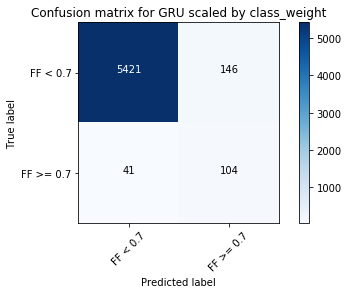

In [59]:
GRU_unweighted_prob = model_25.predict(validation_data)[:,0]
GRU_weighted_prob = GRU_unweighted_prob/((1-GRU_unweighted_prob)/binary_weight+GRU_unweighted_prob)
GRU_weighted_pred = np.round(GRU_weighted_prob)
print "f1 score: %f" % f1_score(validation_target_failure, GRU_weighted_pred)
GRU_weighted_cm = confusion_matrix(validation_target_failure, GRU_weighted_pred)
plot_confusion_matrix(GRU_weighted_cm,["FF < %.1f"%threshold, "FF >= %.1f"%threshold],title='Confusion matrix for GRU scaled by class_weight')

f1 score: 0.477419
[[5476   91]
 [  71   74]]


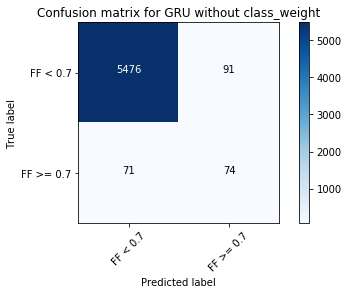

In [60]:
GRU_unweighted_pred = np.round(GRU_unweighted_prob)
print "f1 score: %f" % f1_score(validation_target_failure, GRU_unweighted_pred)
GRU_unweighted_cm = confusion_matrix(validation_target_failure, GRU_unweighted_pred)
plot_confusion_matrix(GRU_unweighted_cm,["FF < %.1f"%threshold, "FF >= %.1f"%threshold],title='Confusion matrix for GRU without class_weight')

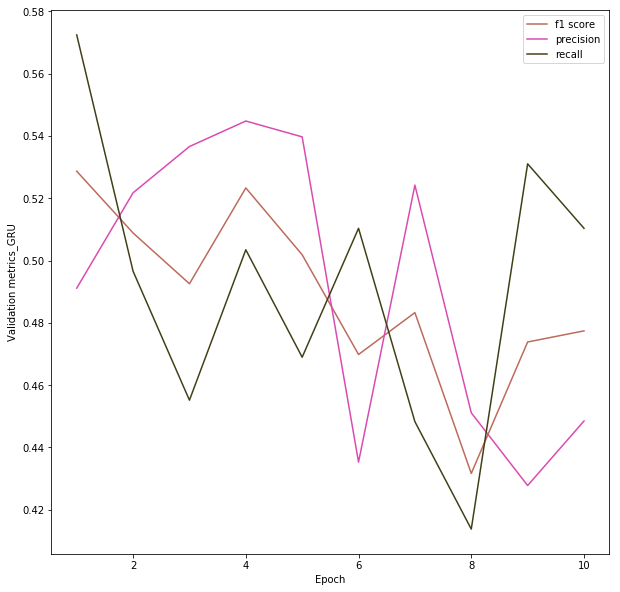

In [115]:
epoch_GRU = np.arange(1,11)
plt.figure(figsize=(10,10))
plt.plot(epoch_GRU, metrics_GRU.val_f1s, color= tuple(np.random.random(3)),label="f1 score")
plt.plot(epoch_GRU, metrics_GRU.val_precisions, color= tuple(np.random.random(3)), label='precision')
plt.plot(epoch_GRU, metrics_GRU.val_recalls, color= tuple(np.random.random(3)), label='recall')
plt.xlabel("Epoch")
plt.ylabel("Validation metrics_GRU")
plt.legend(loc='best')
plt.show()

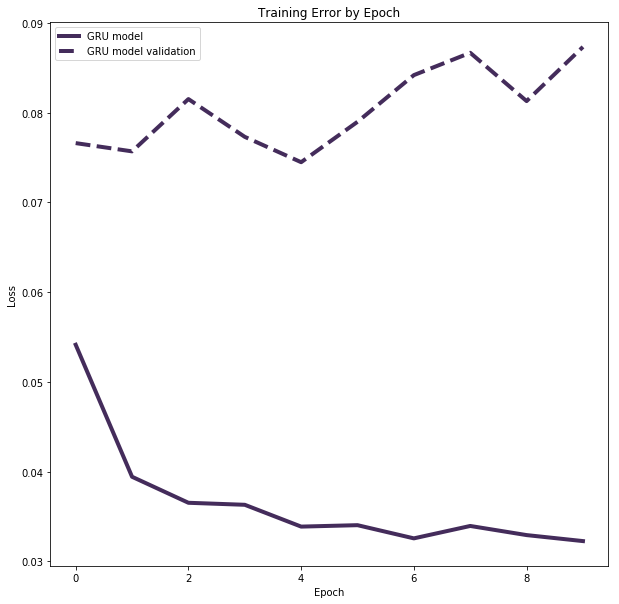

In [62]:
show_losses([("GRU model", hist_25)],acc='binary_accuracy')

# Compare performances between 3 binary classification models.

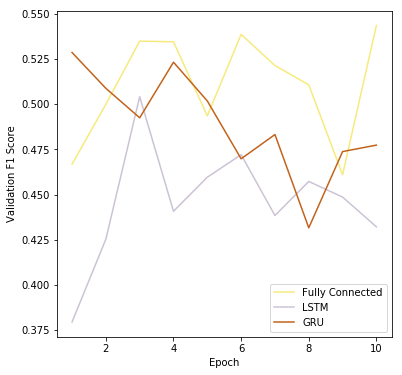

In [122]:
epoch = np.arange(1,11)
plt.figure(figsize=(6,6))
plt.plot(epoch_FC, metrics_FC.val_f1s, color= tuple(np.random.random(3)),label="Fully Connected")
plt.plot(epoch_LSTM, metrics_LSTM.val_f1s, color= tuple(np.random.random(3)), label='LSTM')
plt.plot(epoch_GRU, metrics_GRU.val_f1s, color= tuple(np.random.random(3)), label='GRU')
plt.xlabel("Epoch")
plt.ylabel("Validation F1 Score")
plt.legend(loc='best')
plt.show()

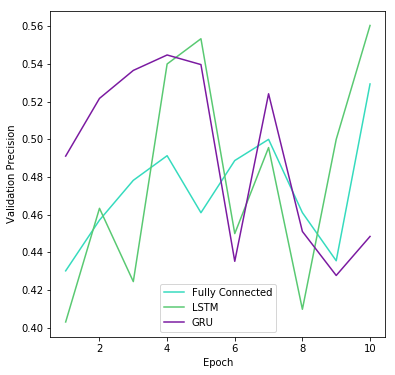

In [121]:
epoch = np.arange(1,11)
plt.figure(figsize=(6,6))
plt.plot(epoch_FC, metrics_FC.val_precisions, color= tuple(np.random.random(3)),label="Fully Connected")
plt.plot(epoch_LSTM, metrics_LSTM.val_precisions, color= tuple(np.random.random(3)), label='LSTM')
plt.plot(epoch_GRU, metrics_GRU.val_precisions, color= tuple(np.random.random(3)), label='GRU')
plt.xlabel("Epoch")
plt.ylabel("Validation Precision")
plt.legend(loc='best')
plt.show()

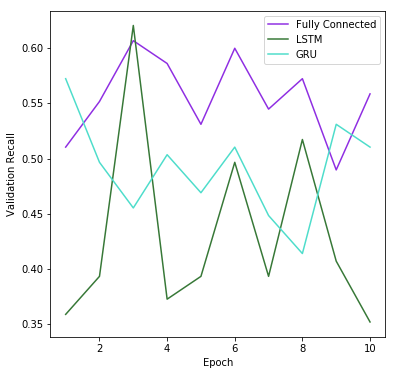

In [120]:
epoch = np.arange(1,11)
plt.figure(figsize=(6,6))
plt.plot(epoch_FC, metrics_FC.val_recalls, color= tuple(np.random.random(3)),label="Fully Connected")
plt.plot(epoch_LSTM, metrics_LSTM.val_recalls, color= tuple(np.random.random(3)), label='LSTM')
plt.plot(epoch_GRU, metrics_GRU.val_recalls, color= tuple(np.random.random(3)), label='GRU')
plt.xlabel("Epoch")
plt.ylabel("Validation Recall")
plt.legend(loc='best')
plt.show()

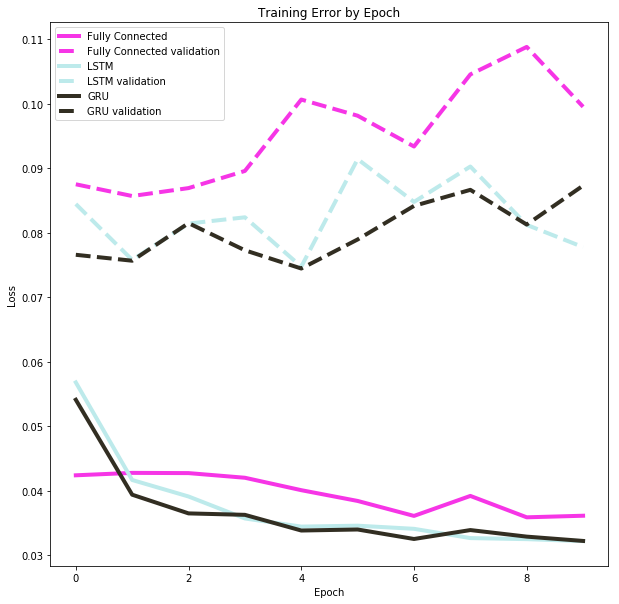

In [119]:
show_losses([("Fully Connected", hist), ("LSTM", hist_2), ("GRU", hist_25)],acc='binary_accuracy')

# Now do regression prediction

# Model 3: Fully connected (Regression)

In [63]:
i = layers.Input((nb_sites,nb_errors,train_layers))
f = layers.Flatten()(i)
layer = layers.Dense(1000, activation='relu')(f)
layer = layers.Dense(1000, activation='relu')(layer)
layer = layers.Dense(100, activation='relu')(layer)
d = layers.Dense(10, activation='relu')(layer)
o = layers.Dense(1)(d)
model_3 = Model(i,o)
model_3.compile(loss="mean_squared_error", optimizer="rmsprop", metrics = ['mean_squared_error','mean_absolute_error'])

In [79]:
model_3.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_8 (InputLayer)             (None, 74, 159, 9)    0                                            
____________________________________________________________________________________________________
flatten_2 (Flatten)              (None, 105894)        0           input_8[0][0]                    
____________________________________________________________________________________________________
dense_18 (Dense)                 (None, 1000)          105895000   flatten_2[0][0]                  
____________________________________________________________________________________________________
dense_19 (Dense)                 (None, 1000)          1001000     dense_18[0][0]                   
___________________________________________________________________________________________

In [80]:
hist_3 = model_3.fit(training_data, raw_final_fraction, 
          validation_data=(validation_data, raw_validation_final_fraction),
          nb_epoch=10,
          batch_size=32,
          #class_weight=binary_class_weight,
          #callbacks=[EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min'),
          #                  ModelCheckpoint(filepath='simple.h5', verbose=0)]
         )

Train on 32374 samples, validate on 5712 samples
Epoch 1/10
32374/32374 [==============================] - 33s - loss: 0.0370 - mean_squared_error: 0.0370 - mean_absolute_error: 0.0443 - val_loss: 0.0392 - val_mean_squared_error: 0.0392 - val_mean_absolute_error: 0.0674
Epoch 2/10
32374/32374 [==============================] - 33s - loss: 0.0535 - mean_squared_error: 0.0535 - mean_absolute_error: 0.0435 - val_loss: 0.0316 - val_mean_squared_error: 0.0316 - val_mean_absolute_error: 0.0618
Epoch 3/10
32374/32374 [==============================] - 33s - loss: 0.0320 - mean_squared_error: 0.0320 - mean_absolute_error: 0.0427 - val_loss: 0.0681 - val_mean_squared_error: 0.0681 - val_mean_absolute_error: 0.0682
Epoch 4/10
32374/32374 [==============================] - 33s - loss: 0.0312 - mean_squared_error: 0.0312 - mean_absolute_error: 0.0442 - val_loss: 0.0323 - val_mean_squared_error: 0.0323 - val_mean_absolute_error: 0.0603
Epoch 5/10
32374/32374 [==============================] - 33s -

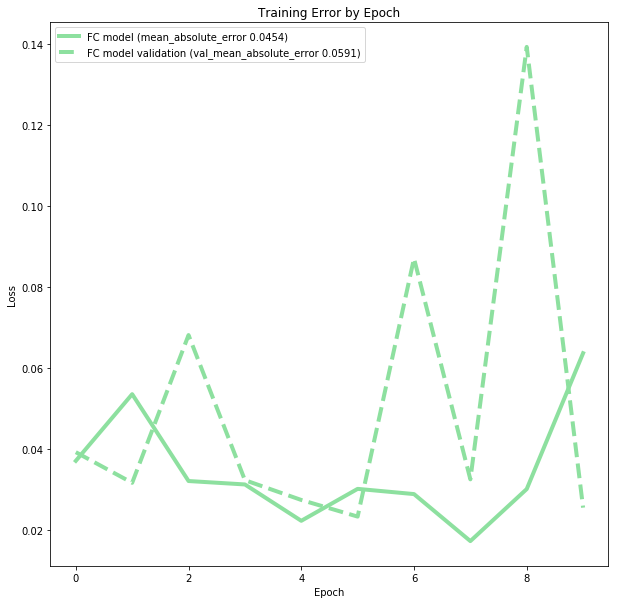

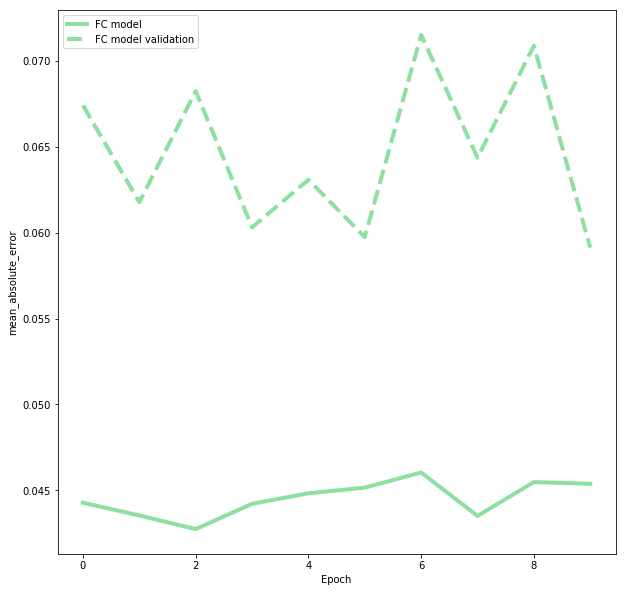

In [82]:
show_losses([("FC model", hist_3)],acc='mean_absolute_error')

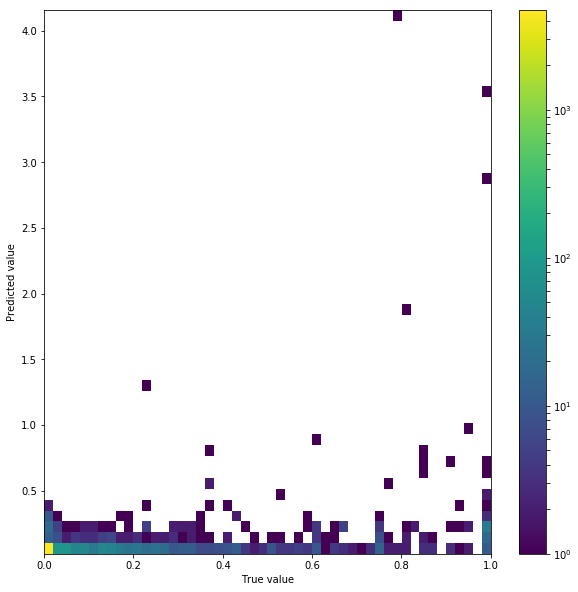

In [91]:
Flatten_regression_pred = model_3.predict(validation_data)[:,0]
plt.figure(figsize=(10,10))
plt.hist2d(raw_validation_final_fraction,Flatten_regression_pred, bins=50,norm=LogNorm())
plt.colorbar()
plt.xlabel("True value")
plt.ylabel("Predicted value")
plt.show()

# Model 4: LSTM for Regression

## Pure LSTM

In [93]:
def build_model_4():
    main_input = layers.Input(shape=(nb_sites,nb_errors,train_layers))
    layer = layers.Permute(dims=(3,1,2), input_shape=(nb_sites,nb_errors,train_layers))(main_input)
    layer = layers.Reshape((train_layers,matrix_dim))(layer)
    layer = layers.Dense(100, input_dim = matrix_dim)(layer)
    layer = layers.LSTM(128, return_sequences=True)(layer)
    layer = layers.Dropout(0.5)(layer)
    layer = layers.LSTM(128, return_sequences=True)(layer)
    layer = layers.Dropout(0.5)(layer)
    layer = layers.LSTM(128, return_sequences=False)(layer)
    layer = layers.Dropout(0.5)(layer)
    layer = layers.Dense(128, activation='relu')(layer)
    output = layers.Dense(1)(layer)
    model = Model(main_input,output)
    model.summary()
    model.compile(loss="mean_squared_error", optimizer="rmsprop", metrics = ['mean_squared_error','mean_absolute_error'])
    return model

In [97]:
# train the model
model_4 = build_model_4()

hist_4 = model_4.fit(training_data, raw_final_fraction, 
          validation_data = [validation_data, raw_validation_final_fraction],
          nb_epoch=1000,
          batch_size=32,
          verbose=1,
          callbacks=[EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min')]
          #ModelCheckpoint(filepath='simple_9.h5', verbose=0)
         )


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_10 (InputLayer)            (None, 74, 159, 9)    0                                            
____________________________________________________________________________________________________
permute_8 (Permute)              (None, 9, 74, 159)    0           input_10[0][0]                   
____________________________________________________________________________________________________
reshape_8 (Reshape)              (None, 9, 11766)      0           permute_8[0][0]                  
____________________________________________________________________________________________________
dense_26 (Dense)                 (None, 9, 100)        1176700     reshape_8[0][0]                  
___________________________________________________________________________________________

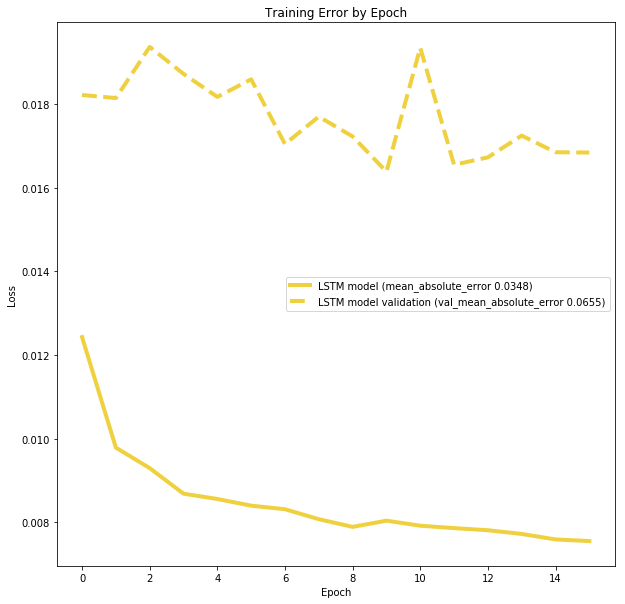

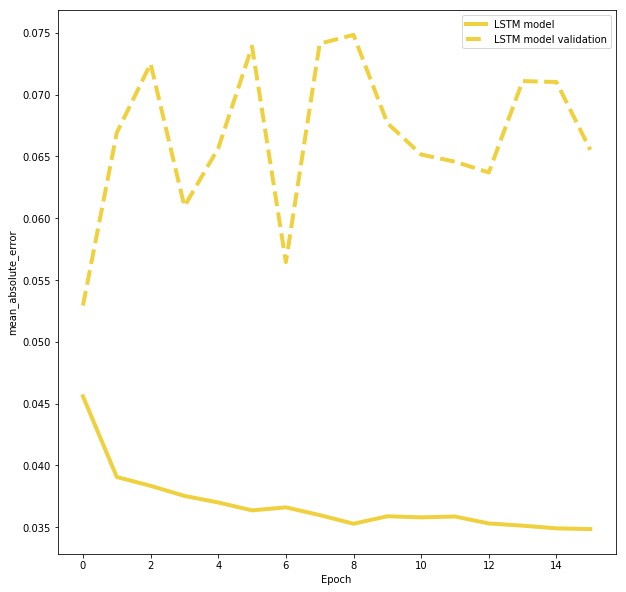

In [98]:
show_losses([("LSTM model", hist_4)],acc='mean_absolute_error')

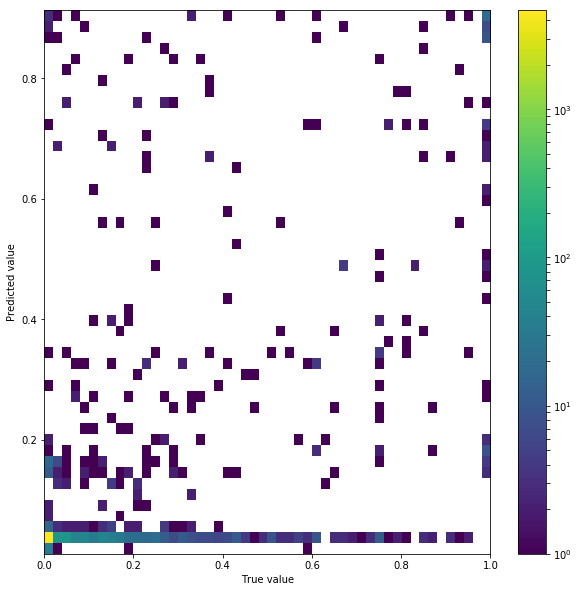

In [99]:
LSTM_regression_pred = model_4.predict(validation_data)[:,0]
plt.figure(figsize=(10,10))
plt.hist2d(raw_validation_final_fraction,LSTM_regression_pred, bins=50,norm=LogNorm())
plt.colorbar()
plt.xlabel("True value")
plt.ylabel("Predicted value")
plt.show()

## Pure GRU

In [100]:
def build_model_45():
    main_input = layers.Input(shape=(nb_sites,nb_errors,train_layers))
    layer = layers.Permute(dims=(3,1,2), input_shape=(nb_sites,nb_errors,train_layers))(main_input)
    layer = layers.Reshape((train_layers,matrix_dim))(layer)
    layer = layers.Dense(100, input_dim = matrix_dim)(layer)
    layer = layers.GRU(128, return_sequences=True)(layer)
    layer = layers.Dropout(0.5)(layer)
    layer = layers.GRU(128, return_sequences=True)(layer)
    layer = layers.Dropout(0.5)(layer)
    layer = layers.GRU(128, return_sequences=False)(layer)
    layer = layers.Dropout(0.5)(layer)
    layer = layers.Dense(128, activation='relu')(layer)
    output = layers.Dense(1)(layer)
    model = Model(main_input,output)
    model.summary()
    model.compile(loss="mean_squared_error", optimizer="rmsprop", metrics = ['mean_squared_error','mean_absolute_error'])
    return model

In [101]:
# train the model
model_45 = build_model_45()

hist_45 = model_45.fit(training_data, raw_final_fraction, 
          validation_data = [validation_data, raw_validation_final_fraction],
          nb_epoch=1000,
          batch_size=32,
          verbose=1,
          callbacks=[EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min')]
          #ModelCheckpoint(filepath='simple_9.h5', verbose=0)
         )


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_11 (InputLayer)            (None, 74, 159, 9)    0                                            
____________________________________________________________________________________________________
permute_9 (Permute)              (None, 9, 74, 159)    0           input_11[0][0]                   
____________________________________________________________________________________________________
reshape_9 (Reshape)              (None, 9, 11766)      0           permute_9[0][0]                  
____________________________________________________________________________________________________
dense_29 (Dense)                 (None, 9, 100)        1176700     reshape_9[0][0]                  
___________________________________________________________________________________________

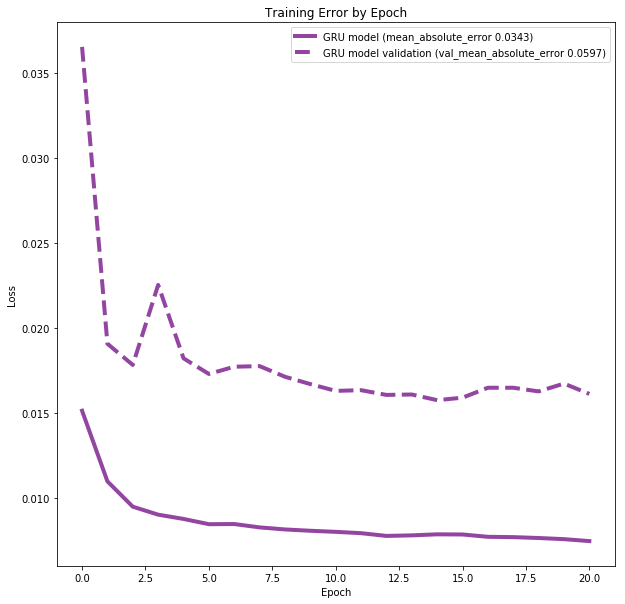

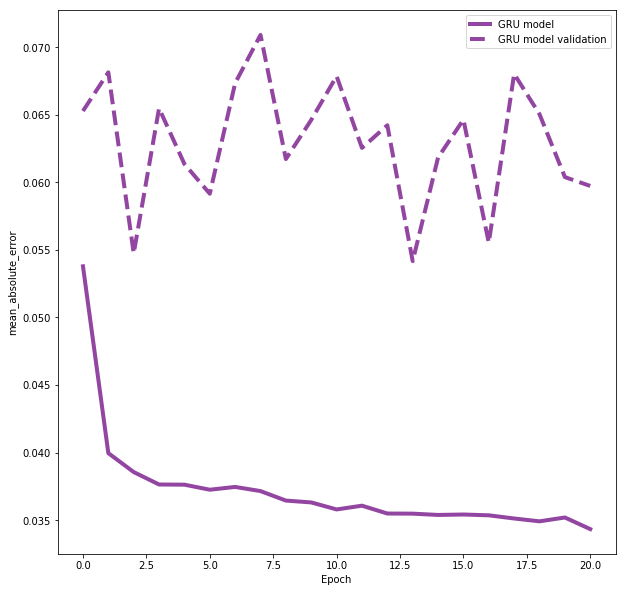

In [102]:
show_losses([("GRU model", hist_45)],acc='mean_absolute_error')

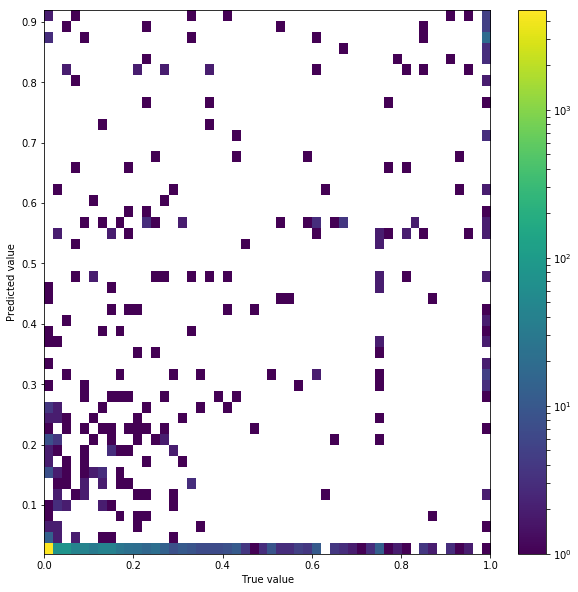

In [103]:
GRU_regression_pred = model_45.predict(validation_data)[:,0]
plt.figure(figsize=(10,10))
plt.hist2d(raw_validation_final_fraction,GRU_regression_pred, bins=50,norm=LogNorm())
plt.colorbar()
plt.xlabel("True value")
plt.ylabel("Predicted value")
plt.show()

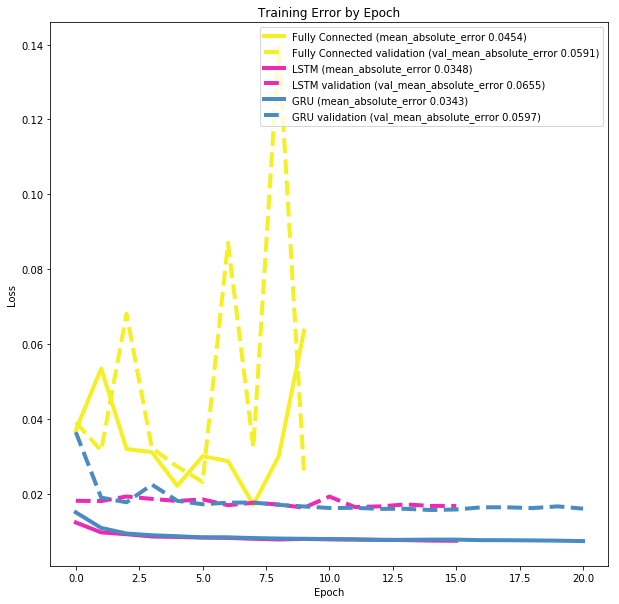

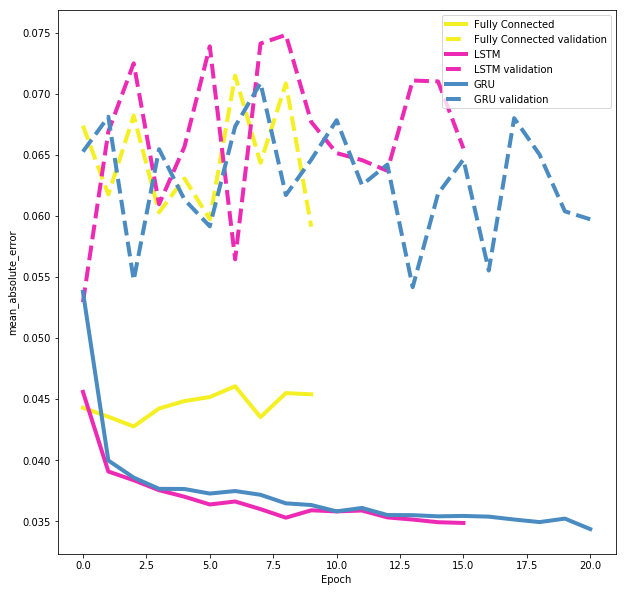

In [123]:
show_losses([("Fully Connected", hist_3), ("LSTM", hist_4), ("GRU", hist_45)],acc='mean_absolute_error')